In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# read data and extract wearer names from json file

data_folder = 'data'
wearer_names = {}

folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder))]
for folder in folders:
    info_json_path = os.path.join(data_folder, folder, 'info.json')

    if os.path.exists(info_json_path):
        with open(info_json_path, 'r') as f:
            info_data = json.load(f)
        wearer_name = info_data['wearer_name']
        wearer_names[folder] = wearer_name

dfs = []

for folder in folders:
    events_csv_path = os.path.join(data_folder, folder, 'events.csv')

    if os.path.exists(events_csv_path):
        df = pd.read_csv(events_csv_path)
        wearer_name = wearer_names[folder]
        df['wearer_name'] = wearer_name
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

df

,recording id,timestamp [ns],name,type,wearer_name
0,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,recording.begin,recording,D01-5302
1,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,install.begin,cloud,D01-5302
2,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016309251847000,install.end,cloud,D01-5302
3,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016330042893000,podcast11.begin,cloud,D01-5302
4,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016370741619000,podcast11.end,cloud,D01-5302
...,...,...,...,...,...
1814,1025bfa1-9e32-40d7-b430-49906153ceef,1712998383300800000,listening51.begin,cloud,D01-0989
1815,1025bfa1-9e32-40d7-b430-49906153ceef,1712998392536494000,listening51.end,cloud,D01-0989
1816,1025bfa1-9e32-40d7-b430-49906153ceef,1712998408489173000,test51.begin,cloud,D01-0989
1817,1025bfa1-9e32-40d7-b430-49906153ceef,1712998423747134000,test51.end,cloud,D01-0989


In [27]:
# how many unique recrding? how many unique wearers?

unique_recording_ids = df['recording id'].nunique()
print("Number of unique recording ids:", unique_recording_ids)

unique_wearer_names = df['wearer_name'].nunique()
print("Number of unique wearer names:", unique_wearer_names)

Number of unique recording ids: 30
Number of unique wearer names: 24


In [28]:
wearer_names_with_multiple_ids = df.groupby('wearer_name').filter(lambda x: x['recording id'].nunique() > 1)['wearer_name'].unique().tolist()
print("Wearer names with more than one recording id:", wearer_names_with_multiple_ids)

Wearer names with more than one recording id: ['D01-3772', 'D02-9545', 'D02-9344', 'D02-4438', 'D02-5452']


remove extra recording labels for those who have more than one recording.

In [29]:
filtered_df = df[df['type'] == 'recording']

In [30]:
df

,recording id,timestamp [ns],name,type,wearer_name
0,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,recording.begin,recording,D01-5302
1,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,install.begin,cloud,D01-5302
2,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016309251847000,install.end,cloud,D01-5302
3,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016330042893000,podcast11.begin,cloud,D01-5302
4,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016370741619000,podcast11.end,cloud,D01-5302
...,...,...,...,...,...
1814,1025bfa1-9e32-40d7-b430-49906153ceef,1712998383300800000,listening51.begin,cloud,D01-0989
1815,1025bfa1-9e32-40d7-b430-49906153ceef,1712998392536494000,listening51.end,cloud,D01-0989
1816,1025bfa1-9e32-40d7-b430-49906153ceef,1712998408489173000,test51.begin,cloud,D01-0989
1817,1025bfa1-9e32-40d7-b430-49906153ceef,1712998423747134000,test51.end,cloud,D01-0989


In [31]:
filtered_df_sorted = filtered_df.sort_values(by='timestamp [ns]')

wearer_counts = filtered_df_sorted['wearer_name'].value_counts()
wearer_names_to_keep = wearer_counts.index[wearer_counts > 2]

dfs_to_concat = []

for name in wearer_names_to_keep:
    wearer_rows = filtered_df_sorted[filtered_df_sorted['wearer_name'] == name]
    
    first_row = wearer_rows.iloc[0]
    last_row = wearer_rows.iloc[-1]
    
    dfs_to_concat.append(first_row.to_frame().T)
    dfs_to_concat.append(last_row.to_frame().T)

filtered_result = pd.concat(dfs_to_concat)

filtered_result_remaining = filtered_df_sorted[~filtered_df_sorted['wearer_name'].isin(wearer_names_to_keep)]

filtered_result = pd.concat([filtered_result, filtered_result_remaining])

filtered_result = filtered_result.sort_values(by='timestamp [ns]')


In [32]:
rows_to_drop_indices = filtered_df_sorted.index.difference(filtered_result.index)
df.drop(rows_to_drop_indices, inplace=True)
df

,recording id,timestamp [ns],name,type,wearer_name
0,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,recording.begin,recording,D01-5302
1,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,install.begin,cloud,D01-5302
2,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016309251847000,install.end,cloud,D01-5302
3,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016330042893000,podcast11.begin,cloud,D01-5302
4,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016370741619000,podcast11.end,cloud,D01-5302
...,...,...,...,...,...
1814,1025bfa1-9e32-40d7-b430-49906153ceef,1712998383300800000,listening51.begin,cloud,D01-0989
1815,1025bfa1-9e32-40d7-b430-49906153ceef,1712998392536494000,listening51.end,cloud,D01-0989
1816,1025bfa1-9e32-40d7-b430-49906153ceef,1712998408489173000,test51.begin,cloud,D01-0989
1817,1025bfa1-9e32-40d7-b430-49906153ceef,1712998423747134000,test51.end,cloud,D01-0989


calculate total duration 

In [33]:
grouped = df.groupby('wearer_name')

total_durations = []

for wearer_name, group in grouped:
    begin_row = group[group['name'] == 'recording.begin']
    end_row = group[group['name'] == 'recording.end']
    
    if not begin_row.empty and not end_row.empty:
        begin_time_ns = begin_row.iloc[0]['timestamp [ns]']
        end_time_ns = end_row.iloc[0]['timestamp [ns]']
        
        time_diff_ns = end_time_ns - begin_time_ns
        
        time_diff_minutes = time_diff_ns / (60.0 * 1e9)  
        
        total_durations.append((wearer_name, time_diff_minutes))

total_duration_df = pd.DataFrame(total_durations, columns=['wearer_name', 'total_duration'])

total_duration_df

,wearer_name,total_duration
0,D01-0131,35.456800
1,D01-0953,38.256783
2,D01-0989,31.717652
3,D01-0993,28.735683
4,D01-2612,29.390017
5,D01-3642,35.519783
6,D01-3772,34.034300
7,D01-5302,38.254417
8,D01-5340,33.072467
9,D01-5864,31.252550


calculate each section duration 

In [34]:
def calculate_duration(df, activity):
    filtered_df = df[df['name'].str.startswith(activity)].copy() 

    filtered_df['timestamp [ns]'] = pd.to_datetime(filtered_df['timestamp [ns]'], unit='ns')

    filtered_df = filtered_df.sort_values(by=['wearer_name', 'timestamp [ns]'])

    grouped = filtered_df.groupby('wearer_name')

    activity_durations = {}
    for name, group in grouped:
        timestamps = group['timestamp [ns]'].reset_index(drop=True)
        time_diffs = timestamps[1::2].reset_index(drop=True) - timestamps[::2].reset_index(drop=True)
        total_duration = time_diffs.sum().total_seconds() / 60 
        activity_durations[name] = total_duration

    result_df = pd.DataFrame(list(activity_durations.items()), columns=['wearer_name', f'{activity}_duration'])

    return result_df


def merge_duration(featured_df, result_df):
    merged_df = pd.merge(featured_df, result_df, on='wearer_name', how='outer')
    return merged_df

activities = ['install', 'listening', 'vocab', 'reading', 'grammar', 'video', 'podcast', 'test', 'quiz']  

featured_df = df.copy()  

for activity in activities:
    result_df = calculate_duration(df, activity)
    featured_df = pd.merge(featured_df, result_df, on='wearer_name', how='outer')
    
featured_df.fillna(0, inplace=True)

featured_df

,recording id,timestamp [ns],name,type,wearer_name,install_duration,listening_duration,vocab_duration,reading_duration,grammar_duration,video_duration,podcast_duration,test_duration,quiz_duration
0,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,recording.begin,recording,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0
1,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,install.begin,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0
2,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016309251847000,install.end,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0
3,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016330042893000,podcast11.begin,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0
4,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016370741619000,podcast11.end,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1802,1025bfa1-9e32-40d7-b430-49906153ceef,1712998383300800000,listening51.begin,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0
1803,1025bfa1-9e32-40d7-b430-49906153ceef,1712998392536494000,listening51.end,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0
1804,1025bfa1-9e32-40d7-b430-49906153ceef,1712998408489173000,test51.begin,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0
1805,1025bfa1-9e32-40d7-b430-49906153ceef,1712998423747134000,test51.end,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0


In [35]:
featured_df = pd.merge(featured_df, total_duration_df, on='wearer_name', how='outer')
featured_df

,recording id,timestamp [ns],name,type,wearer_name,install_duration,listening_duration,vocab_duration,reading_duration,grammar_duration,video_duration,podcast_duration,test_duration,quiz_duration,total_duration
0,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,recording.begin,recording,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417
1,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,install.begin,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417
2,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016309251847000,install.end,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417
3,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016330042893000,podcast11.begin,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417
4,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016370741619000,podcast11.end,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1802,1025bfa1-9e32-40d7-b430-49906153ceef,1712998383300800000,listening51.begin,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652
1803,1025bfa1-9e32-40d7-b430-49906153ceef,1712998392536494000,listening51.end,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652
1804,1025bfa1-9e32-40d7-b430-49906153ceef,1712998408489173000,test51.begin,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652
1805,1025bfa1-9e32-40d7-b430-49906153ceef,1712998423747134000,test51.end,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652


check for any mistakes in labeling: are all duration labels even?

In [36]:
def keyword_count(df, keyword):
    filtered_df = df[df['name'].str.contains(keyword)]

    keyword_counts = filtered_df.groupby('wearer_name').size()

    is_odd = keyword_counts % 2 != 0

    result_df = pd.DataFrame({
        'wearer_name': keyword_counts.index,
        keyword: is_odd
    })

    return result_df

keywords = ['install', 'listening', 'vocab', 'reading', 'grammar', 'video', 'podcast', 'test', 'quiz']  

for keyword in keywords:
    result_df = keyword_count(featured_df, keyword)
    print(f"Odd occurrences for {keyword}:")
    result_df[result_df[keyword]]

Odd occurrences for install:
Odd occurrences for listening:
Odd occurrences for vocab:
Odd occurrences for reading:
Odd occurrences for grammar:
Odd occurrences for video:
Odd occurrences for podcast:
Odd occurrences for test:
Odd occurrences for quiz:


calculate question, notif and distraction counts

In [37]:
def calculate_occurrence(df):
    wearer_names = df['wearer_name'].unique()
    notification_counts = {}
    distraction_counts = {}
    question_counts = {}

    for name in wearer_names:
        wearer_df = df[df['wearer_name'] == name]
        notification_counts[name] = wearer_df['name'].str.contains('notification').sum()
        distraction_counts[name] = wearer_df['name'].str.contains('distraction').sum()
        question_counts[name] = wearer_df['name'].str.contains('question').sum()

    return notification_counts, distraction_counts, question_counts

def merge_occurrence(featured_df, notification_counts, distraction_counts, question_counts):
    featured_df['notification_count'] = featured_df['wearer_name'].map(notification_counts)
    featured_df['distraction_count'] = featured_df['wearer_name'].map(distraction_counts)
    featured_df['question_count'] = featured_df['wearer_name'].map(question_counts)
    return featured_df

notification_counts, distraction_counts, question_counts = calculate_occurrence(df)
featured_df = merge_occurrence(featured_df, notification_counts, distraction_counts, question_counts)

featured_df


,recording id,timestamp [ns],name,type,wearer_name,install_duration,listening_duration,vocab_duration,reading_duration,grammar_duration,video_duration,podcast_duration,test_duration,quiz_duration,total_duration,notification_count,distraction_count,question_count
0,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,recording.begin,recording,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417,0,2,5
1,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016261421000000,install.begin,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417,0,2,5
2,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016309251847000,install.end,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417,0,2,5
3,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016330042893000,podcast11.begin,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417,0,2,5
4,25401c90-225c-4f9e-bf5b-d6a6c1503197,1708016370741619000,podcast11.end,cloud,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.0,38.254417,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1802,1025bfa1-9e32-40d7-b430-49906153ceef,1712998383300800000,listening51.begin,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652,2,8,0
1803,1025bfa1-9e32-40d7-b430-49906153ceef,1712998392536494000,listening51.end,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652,2,8,0
1804,1025bfa1-9e32-40d7-b430-49906153ceef,1712998408489173000,test51.begin,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652,2,8,0
1805,1025bfa1-9e32-40d7-b430-49906153ceef,1712998423747134000,test51.end,cloud,D01-0989,6.677935,1.853245,3.945090,0.120079,0.327360,0.000000,11.439898,1.934539,0.0,31.717652,2,8,0


In [38]:
featured_df.drop_duplicates(subset=['wearer_name'], keep='first', inplace=True)
columns_to_drop = ['timestamp [ns]', 'name', 'type', 'recording id']
featured_df.drop(columns=columns_to_drop, inplace=True)
featured_df.reset_index(drop=True, inplace=True)

featured_df


,wearer_name,install_duration,listening_duration,vocab_duration,reading_duration,grammar_duration,video_duration,podcast_duration,test_duration,quiz_duration,total_duration,notification_count,distraction_count,question_count
0,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.000000,38.254417,0,2,5
1,D02-8226,8.629088,4.876409,5.154531,4.800703,1.809550,1.009921,4.466785,3.759492,0.000000,41.679000,2,2,0
2,D01-3772,1.757814,0.827994,0.000000,10.592752,4.329150,3.336998,0.000000,9.567636,0.000000,34.034300,0,3,0
3,D02-7786,4.019021,1.315086,2.886946,0.760807,1.614360,1.793264,1.294990,2.126103,0.000000,25.197800,1,1,0
4,D02-9545,2.511471,2.411044,5.340202,5.011242,2.231007,1.835234,0.000000,5.074624,0.000000,27.500150,2,0,0
5,D01-6310,4.848515,0.932938,0.547170,0.456139,1.509992,0.401590,1.340888,3.085695,0.000000,24.050883,0,3,1
6,D02-4030,3.196718,4.067158,2.250797,6.668980,4.810251,1.972432,0.000000,3.214278,0.000000,33.142900,0,0,11
7,D01-5340,4.194227,3.854340,4.632185,1.086874,3.717605,0.000000,0.000000,5.337669,0.000000,33.072467,5,2,5
8,D02-3569,7.652874,0.000000,3.467003,0.000000,0.000000,0.000000,0.000000,15.994058,3.858636,35.900583,2,0,0
9,D02-9344,2.479708,3.469734,2.554343,7.031555,2.834822,1.308938,0.000000,4.554687,0.000000,44.562950,3,1,0


In [39]:
# featured_df.to_csv('24.csv', index=False)

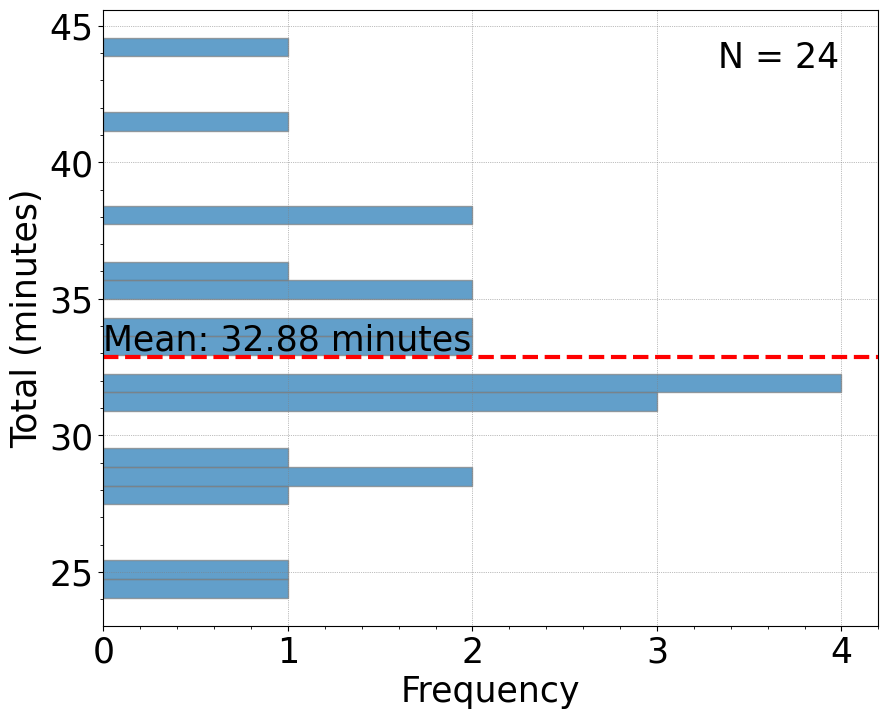

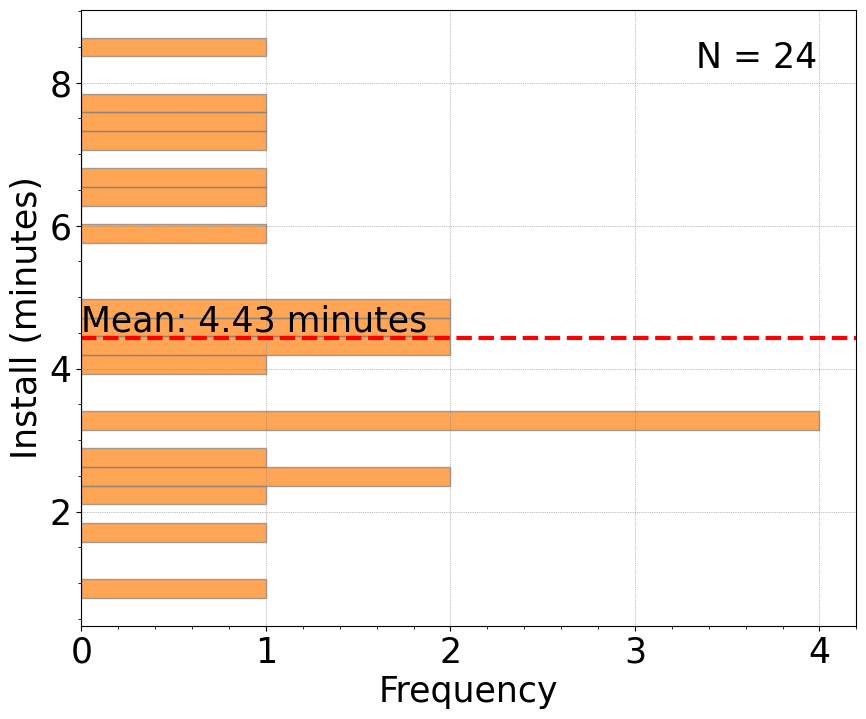

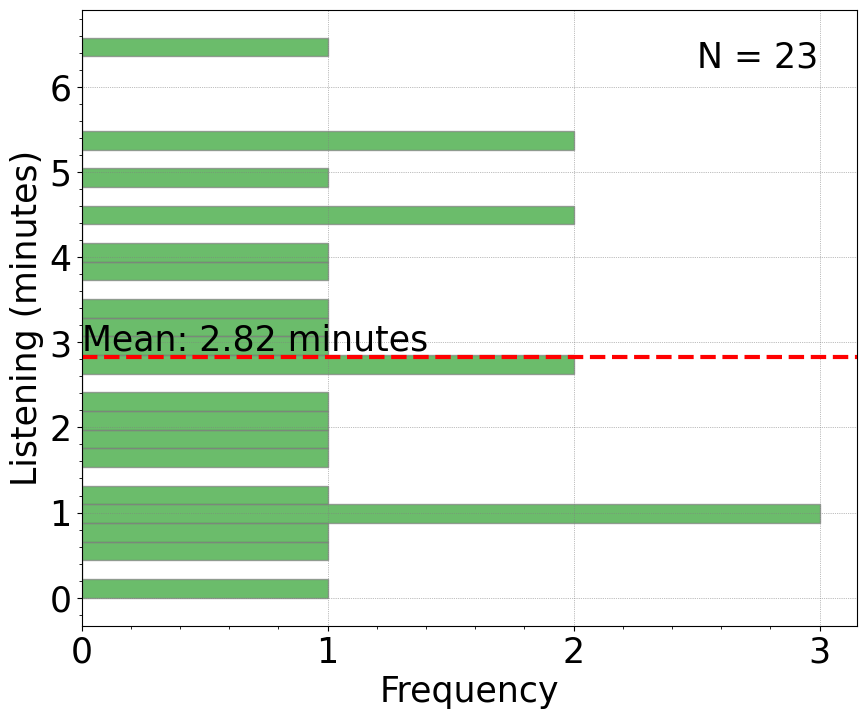

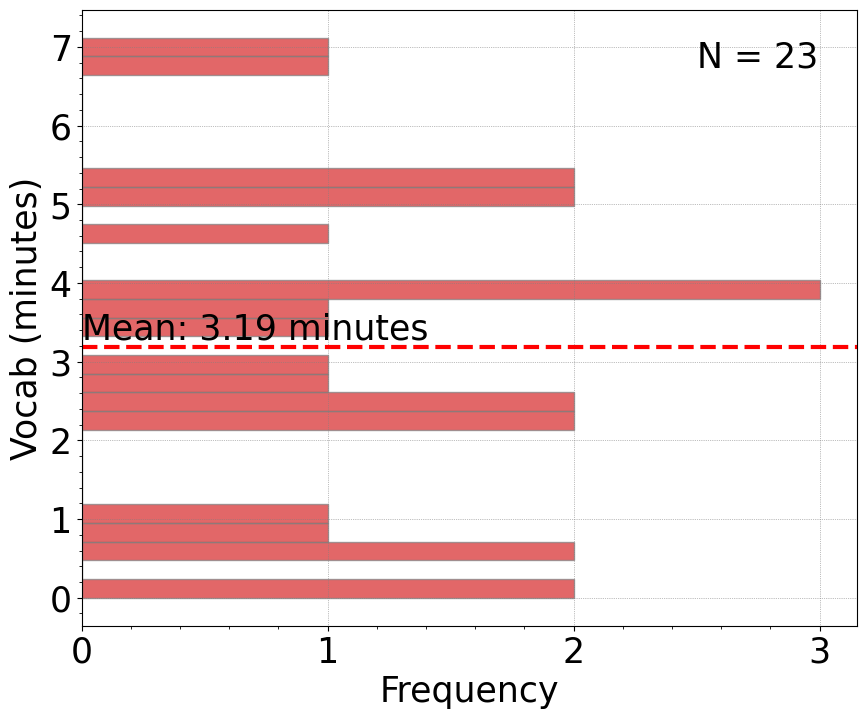

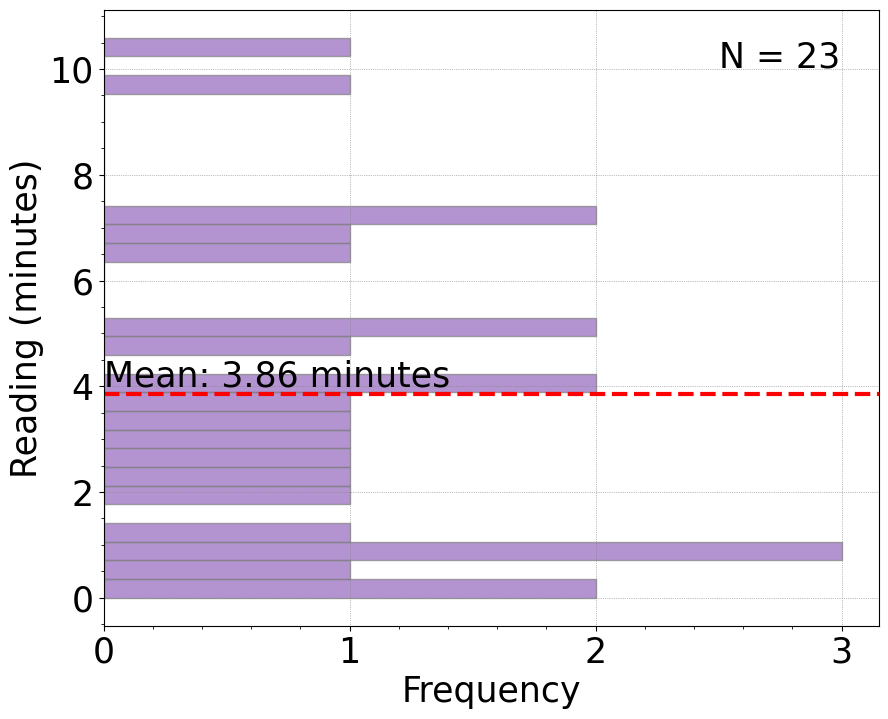

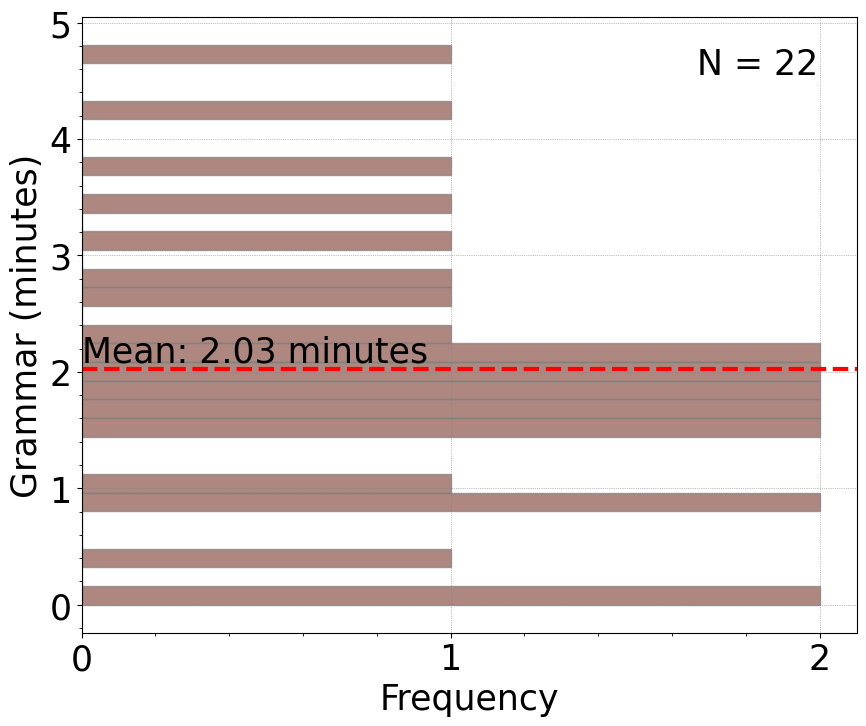

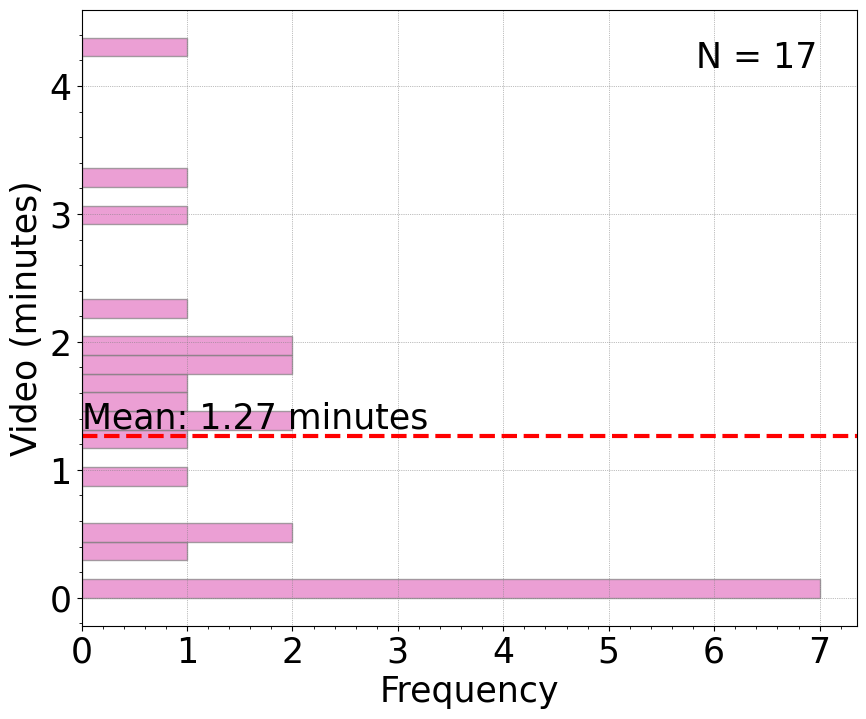

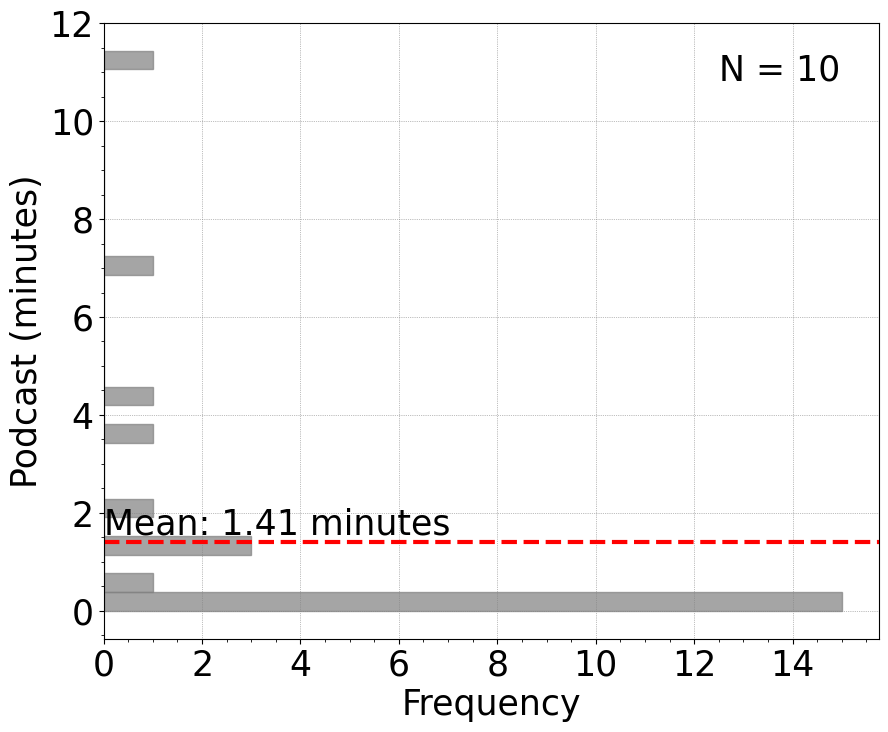

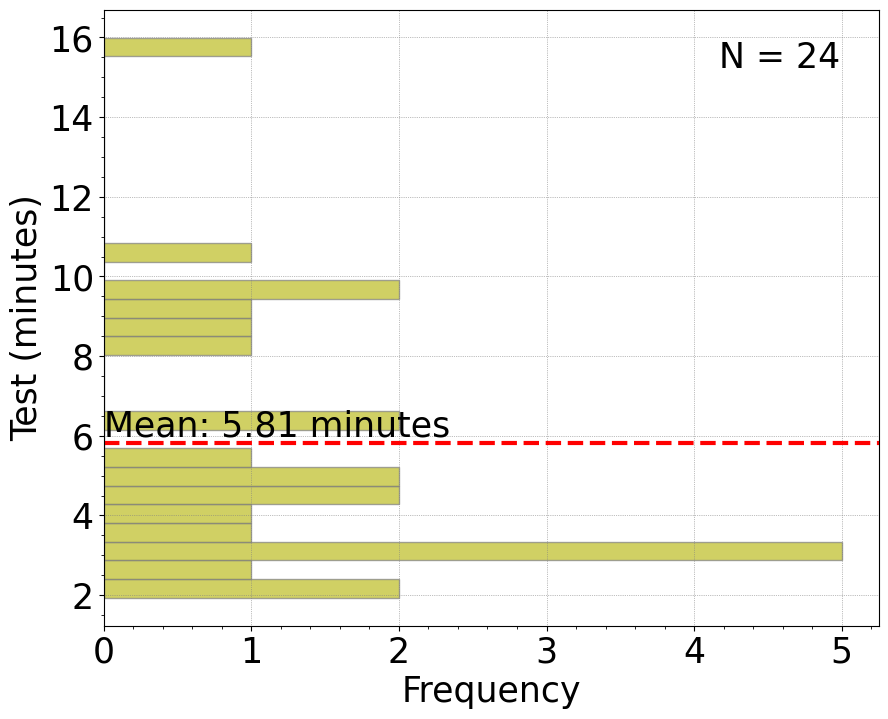

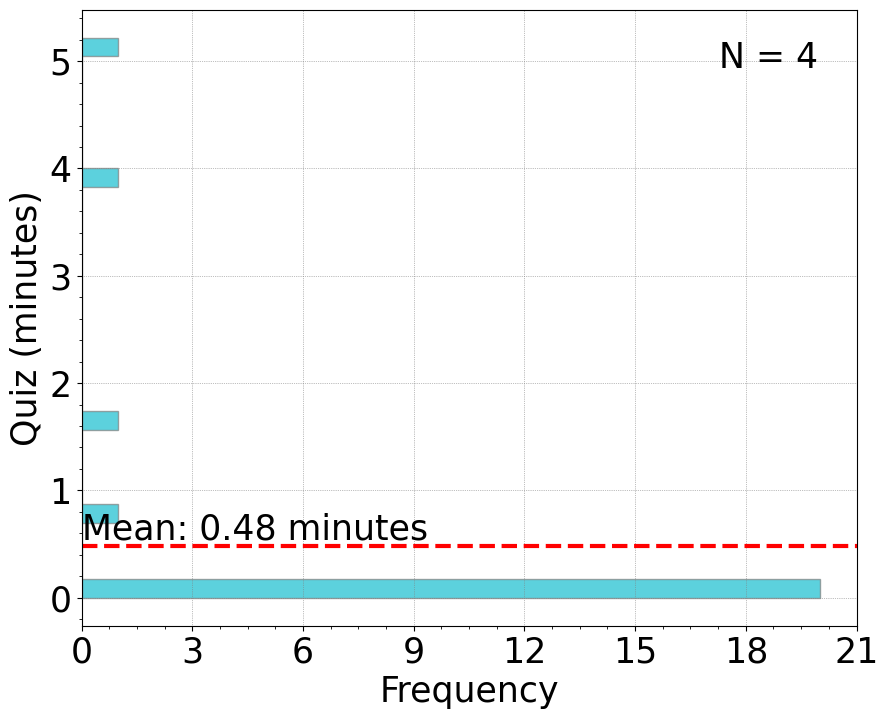

In [40]:
def plot_histogram(featured_df, keyword, color):
    plt.figure(figsize=(10, 8)) 
    plt.hist(featured_df[keyword+'_duration'], bins=30, orientation='horizontal', color=color, alpha=0.7, edgecolor='grey')

    mean_duration = featured_df[keyword+'_duration'].mean()
    keyword_duration = featured_df[keyword+'_duration']
    non_zero_count = (keyword_duration != 0).sum()

    plt.axhline(y=mean_duration, color='r', linestyle='--', linewidth=3)
    plt.text(0, mean_duration, f'Mean: {mean_duration:.2f} minutes', color='black', va='bottom', ha='left', fontsize=25)

    plt.xlabel('Frequency', fontsize=25)
    plt.ylabel(f'{keyword.capitalize()} (minutes)', fontsize=25)

    plt.tick_params(axis='both', labelsize=25)
    plt.gca().get_xaxis().set_major_locator(plt.MaxNLocator(integer=True)) 
    plt.text(0.95, 0.95, f'N = {non_zero_count}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=25)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle=':', linewidth=0.5)

    # plt.title(f'Histogram of {keyword.capitalize()} Duration', fontsize=30, pad=20)

    plt.show()

keywords = ['total', 'install', 'listening', 'vocab', 'reading', 'grammar', 'video', 'podcast', 'test', 'quiz']  
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for keyword, color in zip(keywords, colors):
    plot_histogram(featured_df, keyword, color)


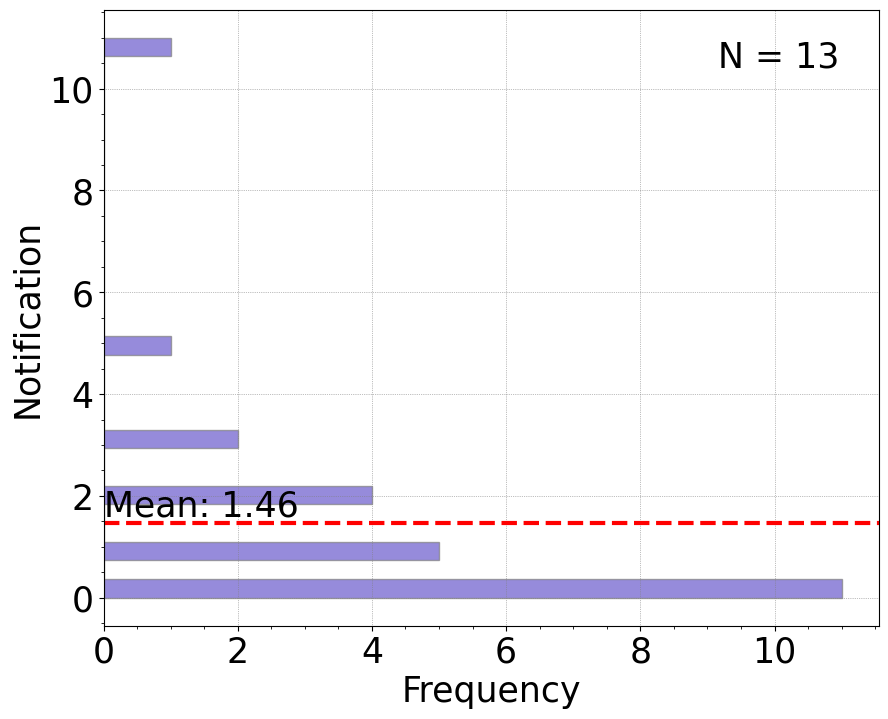

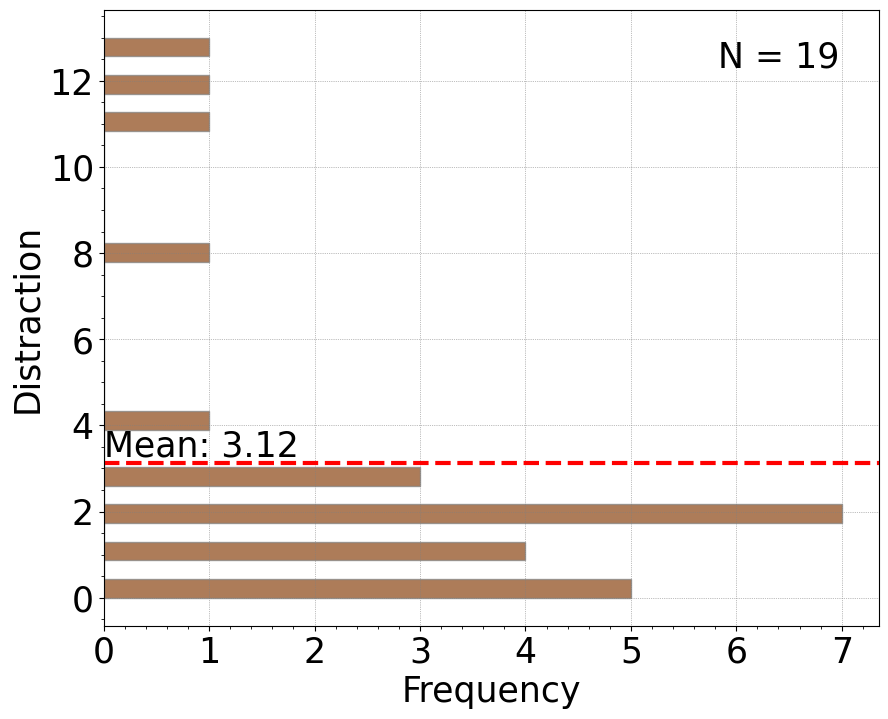

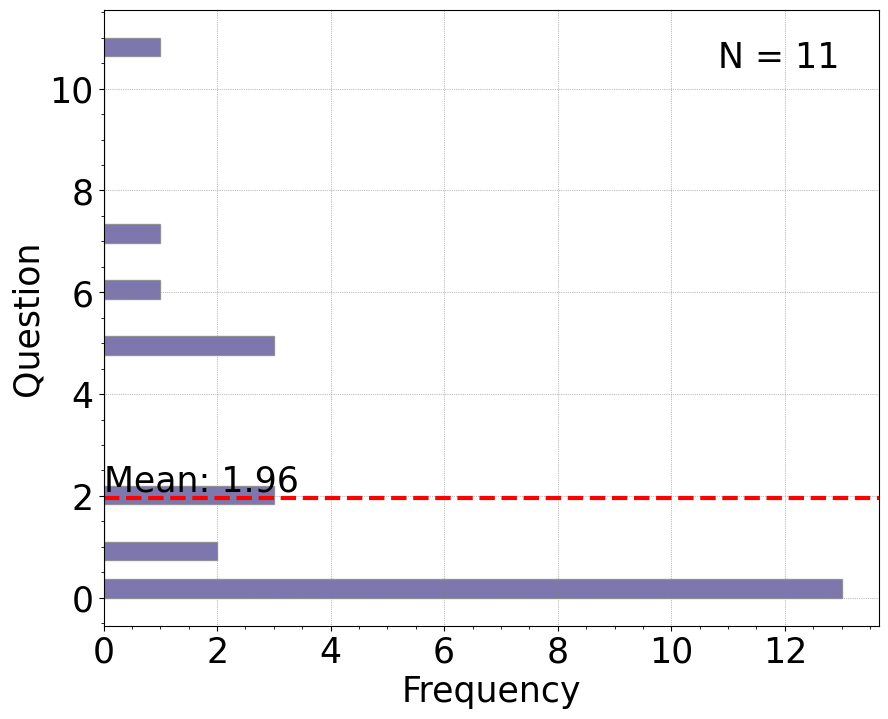

In [41]:
def plot_histogram(featured_df, keyword, color):
    plt.figure(figsize=(10, 8)) 
    plt.hist(featured_df[keyword+'_count'], bins=30, orientation='horizontal', color=color, alpha=0.7, edgecolor='grey')

    mean_duration = featured_df[keyword+'_count'].mean()
    keyword_duration = featured_df[keyword+'_count']
    non_zero_count = (keyword_duration != 0).sum()

    plt.axhline(y=mean_duration, color='r', linestyle='--', linewidth=3)
    plt.text(0, mean_duration, f'Mean: {mean_duration:.2f}', color='black', va='bottom', ha='left', fontsize=25)

    plt.xlabel('Frequency', fontsize=25)
    plt.ylabel(f'{keyword.capitalize()}', fontsize=25)

    plt.tick_params(axis='both', labelsize=25)
    plt.gca().get_xaxis().set_major_locator(plt.MaxNLocator(integer=True)) 
    plt.text(0.95, 0.95, f'N = {non_zero_count}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=25)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle=':', linewidth=0.5)


    plt.show()

keywords = ['notification', 'distraction', 'question']  
colors = ['#6a5acd', '#8b4513', '#483d8b', '#2e8b57', '#696969', '#cd853f', '#9370db', '#556b2f', '#8b008b', '#4682b4']



for keyword, color in zip(keywords, colors):
    plot_histogram(featured_df, keyword, color)


In [42]:
zero_notif = featured_df[featured_df['notification_count'] < 2]
print(len(zero_notif))

16


In [43]:
# featured_df.to_csv('24.csv', index=False)
featured_df = pd.read_csv('merged.csv')

In [44]:
featured_df

,wearer_name,install_duration,listening_duration,vocab_duration,reading_duration,grammar_duration,video_duration,podcast_duration,test_duration,quiz_duration,...,MaxLesson,subscription_price,favourite_part,least_favourite_part,age,gender,colours,graphics,podcast,recommend
0,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.000000,...,5.0,D,آزمون,پادکست,40-50,F,3,2,پادکست را امتحان کردم و خوشم نیامد.,1
1,D02-8226,8.629088,4.876409,5.154531,4.800703,1.809550,1.009921,4.466785,3.759492,0.000000,...,7.0,F,شنیداری,دستور زبان (گرامر),30-40,M,4,3,پادکست را امتحان کردم و برایم جالب بود.,3
2,D01-3772,1.757814,0.827994,0.000000,10.592752,4.329150,3.336998,0.000000,9.567636,0.000000,...,12.0,C,دستور زبان (گرامر),ویدئوهای آموزشی,30-40,M,2,2,پادکست را گوش ندادم چون وقت کافی نبود.,4
3,D02-7786,4.019021,1.315086,2.886946,0.760807,1.614360,1.793264,1.294990,2.126103,0.000000,...,3.0,F,یاد گرفتن لغات,دستور زبان (گرامر),30-40,M,1,1,پادکست را امتحان کردم و خوشم نیامد.,1
4,D02-9545,2.511471,2.411044,5.340202,5.011242,2.231007,1.835234,0.000000,5.074624,0.000000,...,4.0,B,دستور زبان (گرامر),دستور زبان (گرامر),50-60,M,2,3,پادکست را امتحان کردم و برایم جالب بود.,4
5,D01-6310,4.848515,0.932938,0.547170,0.456139,1.509992,0.401590,1.340888,3.085695,0.000000,...,6.0,H,ویدئوهای آموزشی,دستور زبان (گرامر);خواندن,40-50,F,1,2,پادکست را امتحان کردم و برایم جالب بود.,4
6,D02-4030,3.196718,4.067158,2.250797,6.668980,4.810251,1.972432,0.000000,3.214278,0.000000,...,5.0,G,یاد گرفتن لغات,هیچکدام,50-60,M,2,2,پادکست را امتحان کردم و برایم جالب بود.,3
7,D01-5340,4.194227,3.854340,4.632185,1.086874,3.717605,0.000000,0.000000,5.337669,0.000000,...,6.0,E,یاد گرفتن لغات;آزمون,هیچکدام,40-50,M,2,2,نتوانستم از قسمت پادکست استفاده کنم.,5
8,D02-3569,7.652874,0.000000,3.467003,0.000000,0.000000,0.000000,0.000000,15.994058,3.858636,...,26.0,G,آزمون,هیچکدام,40-50,M,2,2,قسمت پادکست اصلا به چشمم نخورد.,5
9,D02-9344,2.479708,3.469734,2.554343,7.031555,2.834822,1.308938,0.000000,4.554687,0.000000,...,7.0,G,خواندن;ویدئوهای آموزشی;پادکست,دستور زبان (گرامر),30-40,F,2,2,پادکست را امتحان کردم و برایم جالب بود.,4


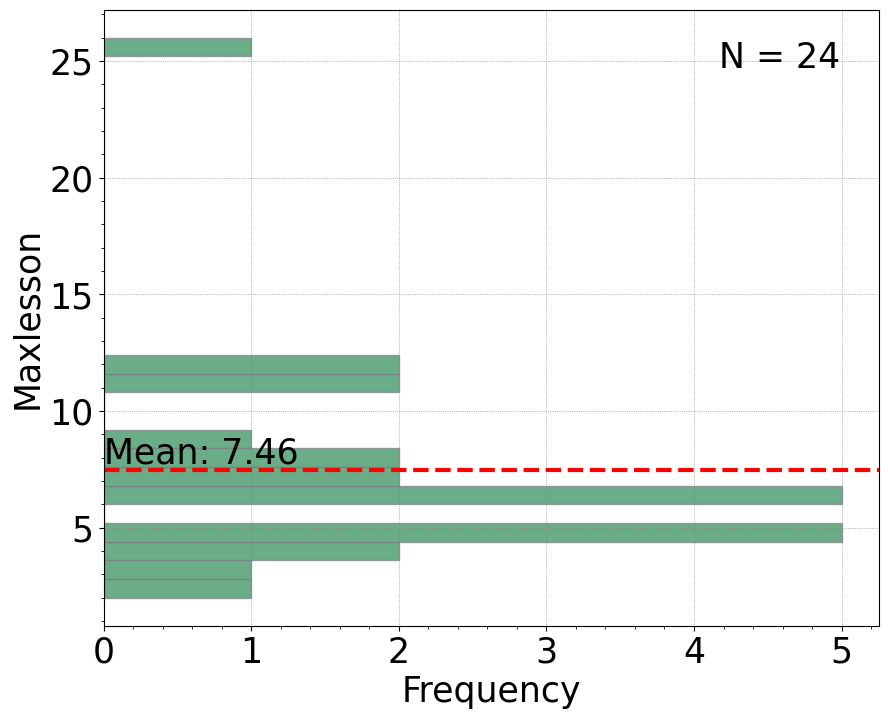

In [45]:
def plot_histogram(featured_df, keyword, color):
    plt.figure(figsize=(10, 8)) 
    plt.hist(featured_df[keyword], bins=30, orientation='horizontal', color=color, alpha=0.7, edgecolor='grey')

    mean_duration = featured_df[keyword].mean()
    keyword_duration = featured_df[keyword]
    non_zero_count = (keyword_duration != 0).sum()

    plt.axhline(y=mean_duration, color='r', linestyle='--', linewidth=3)
    plt.text(0, mean_duration, f'Mean: {mean_duration:.2f}', color='black', va='bottom', ha='left', fontsize=25)

    plt.xlabel('Frequency', fontsize=25)
    plt.ylabel(f'{keyword.capitalize()}', fontsize=25)

    plt.tick_params(axis='both', labelsize=25)
    plt.gca().get_xaxis().set_major_locator(plt.MaxNLocator(integer=True)) 
    plt.text(0.95, 0.95, f'N = {non_zero_count}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=25)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle=':', linewidth=0.5)


    plt.show()

keywords = ['MaxLesson']  
colors = ['#2e8b57', '#696969', '#cd853f', '#9370db', '#556b2f', '#8b008b', '#4682b4']



for keyword, color in zip(keywords, colors):
    plot_histogram(featured_df, keyword, color)


In [46]:
featured_df

,wearer_name,install_duration,listening_duration,vocab_duration,reading_duration,grammar_duration,video_duration,podcast_duration,test_duration,quiz_duration,...,MaxLesson,subscription_price,favourite_part,least_favourite_part,age,gender,colours,graphics,podcast,recommend
0,D01-5302,0.797181,5.463025,2.613458,4.072689,1.816333,1.946836,6.996892,2.964282,0.000000,...,5.0,D,آزمون,پادکست,40-50,F,3,2,پادکست را امتحان کردم و خوشم نیامد.,1
1,D02-8226,8.629088,4.876409,5.154531,4.800703,1.809550,1.009921,4.466785,3.759492,0.000000,...,7.0,F,شنیداری,دستور زبان (گرامر),30-40,M,4,3,پادکست را امتحان کردم و برایم جالب بود.,3
2,D01-3772,1.757814,0.827994,0.000000,10.592752,4.329150,3.336998,0.000000,9.567636,0.000000,...,12.0,C,دستور زبان (گرامر),ویدئوهای آموزشی,30-40,M,2,2,پادکست را گوش ندادم چون وقت کافی نبود.,4
3,D02-7786,4.019021,1.315086,2.886946,0.760807,1.614360,1.793264,1.294990,2.126103,0.000000,...,3.0,F,یاد گرفتن لغات,دستور زبان (گرامر),30-40,M,1,1,پادکست را امتحان کردم و خوشم نیامد.,1
4,D02-9545,2.511471,2.411044,5.340202,5.011242,2.231007,1.835234,0.000000,5.074624,0.000000,...,4.0,B,دستور زبان (گرامر),دستور زبان (گرامر),50-60,M,2,3,پادکست را امتحان کردم و برایم جالب بود.,4
5,D01-6310,4.848515,0.932938,0.547170,0.456139,1.509992,0.401590,1.340888,3.085695,0.000000,...,6.0,H,ویدئوهای آموزشی,دستور زبان (گرامر);خواندن,40-50,F,1,2,پادکست را امتحان کردم و برایم جالب بود.,4
6,D02-4030,3.196718,4.067158,2.250797,6.668980,4.810251,1.972432,0.000000,3.214278,0.000000,...,5.0,G,یاد گرفتن لغات,هیچکدام,50-60,M,2,2,پادکست را امتحان کردم و برایم جالب بود.,3
7,D01-5340,4.194227,3.854340,4.632185,1.086874,3.717605,0.000000,0.000000,5.337669,0.000000,...,6.0,E,یاد گرفتن لغات;آزمون,هیچکدام,40-50,M,2,2,نتوانستم از قسمت پادکست استفاده کنم.,5
8,D02-3569,7.652874,0.000000,3.467003,0.000000,0.000000,0.000000,0.000000,15.994058,3.858636,...,26.0,G,آزمون,هیچکدام,40-50,M,2,2,قسمت پادکست اصلا به چشمم نخورد.,5
9,D02-9344,2.479708,3.469734,2.554343,7.031555,2.834822,1.308938,0.000000,4.554687,0.000000,...,7.0,G,خواندن;ویدئوهای آموزشی;پادکست,دستور زبان (گرامر),30-40,F,2,2,پادکست را امتحان کردم و برایم جالب بود.,4
